# Project Definition

## Overview

The data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (Buy One Get One free). Some users might not receive any offer during certain weeks. Not all users receive the same offer, and every offer has a validity period before the offer expires.

The dataset includes transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

## Goal

**The business goal is maximise the benefits generated by the offers being sent.**

It is needed to highlight that some customers might make a purchase without having received an offer or seen an offer. A customer can receive an offer, never actually view it but still complete it. Then, there is no benefit for the business in such an offer. On the other hand, some customers being influenced by the offer will complete it given that they viewed it. 

Then, the objective is to distinguish these two profiles in order to decide whom a given offer should be send to.

## Metrics

$F_{1}$ score is the metric applied to assesss the performance of the considered models, which is defined as the harmonic mean of $precision$ and $recall$ as depicted in the next formula:

$F_{1} = 2 * (precision * recall) * (precision + recall)^{-1}$

The $precision$ metric is the relationship between the number of the identified true positive results and the number of both true and false positive results. The *recall* metric is the relationship between the number of the identified true positive results and the overall number of positivee entries should have been identified. Following formulae formally describe both metrics.

$precision = true\_positives * (true\_positives + false\_positives)^{-1}$

$recall = true\_positives * (true\_positives + false\_negatives)^{-1}$

# Data analysis

## Exploration and visualization

*portfolio.json*
* id (string) - offer id
* offer_type (string) - allowed values: `bogo`, `discount`, `informational`.
* difficulty (int) - minimum required spend to complete an offer.
* reward (int) - reward given for completing an offer.
* duration (int) - time for offer to be open, in days.
* channels (list of strings) - allowed values: `web`, `email`, `mobile`, `social`.

*profile.json*
* age (int) - age of the customer.
* became_member_on (int) - date when customer created an app account.
* gender (str) - customer's gender. Allowed values: `O` (other), `M` (male), or `F` (female).
* id (str) - customer id.
* income (float) - customer's income.

*transcript.json*
* event (str) - record description. Allowed values: `transaction`, `offer received`, `offer viewed`, `offer completed`.
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Portfolio data overview 

Shows an overview of portfolio data, comprising:
 
* First 5 rows of the dataset
* An overview of columns (column name, number of non null values, and data type)    
* Statistics per columns (count, mean, standard deviation, and quartiles)
* A pie plot depicting the number of offers per type. 

In [2]:
# read in the portfolio json file
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [3]:
# show first 5 rows of the dataset
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# show portfolio columns overview, looking for null values and double checking data types
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
# show statistics per numerical column, double checking non existence of negative values
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
# double checking offer types allowed values
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [7]:
# double checking channels allowed values
channels = set([channel for offer in portfolio.channels for channel in offer])
channels

{'email', 'mobile', 'social', 'web'}

In [8]:
# number of offers per type
offer_type_stats = portfolio.groupby('offer_type').size()
offer_type_stats

offer_type
bogo             4
discount         4
informational    2
dtype: int64

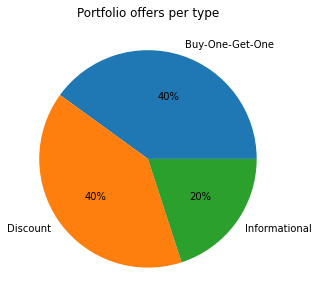

In [9]:
# pie plotting offers per type
offer_type_stats = portfolio.groupby('offer_type').size()

plt.figure(figsize=(5,5))
plt.pie(offer_type_stats, 
        labels=['Buy-One-Get-One', 'Discount', 'Informational'],
        autopct='%1.0f%%')
plt.title('Portfolio offers per type')
plt.show()

### Profile data overview

Shows an overview of portfolio data, comprising:

* First 5 rows of the dataset
* An overview of columns (column name, number of non null values, and data type)    
* Statistics per columns (count, mean, standard deviation, and quartiles)
* A pie plot depicting profiles per gender
* A profile age histogram 
* A profile income histogram
* A heatmap depicting the correlation between age, income, and gender.

In [10]:
# read in the profile json file
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [11]:
# show first 5 rows of the dataset
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
# show profile columns overview, looking for null values and double checking data types
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
# double checking genre allowed values
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

By reviewing the above information, it turns out to be suspicious the number of profiles without `gender` and `income` information be the same. Let's compare them with the profiles without age information, depicted as `age` = 118.

In [14]:
print(f"Number of profiles without `age` information: {profile.query('age == 118').shape[0]}")
print(f"Number of profiles without `income` information: {profile.query('income.isna()').shape[0]}")
print(f"Number of profiles without `gender` information: {profile.query('gender.isna()').shape[0]}")
print(f"`income` unique values of profile without `age` information: {profile.query('age == 118').income.unique()}")
print(f"`gender` unique values of profile without `age` information: {profile.query('age == 118').gender.unique()}")

Number of profiles without `age` information: 2175
Number of profiles without `income` information: 2175
Number of profiles without `gender` information: 2175
`income` unique values of profile without `age` information: [nan]
`gender` unique values of profile without `age` information: [None]


**Then, the 2175 profiles without `age` information do not have neither `income` nor `gender` information**

In [15]:
# show statistics per numerical column, double checking non existence of negative values
profile[['income', 'age']].describe()

,income,age
count,14825.000000,17000.000000
mean,65404.991568,62.531412
std,21598.299410,26.738580
min,30000.000000,18.000000
25%,49000.000000,45.000000
50%,64000.000000,58.000000
75%,80000.000000,73.000000
max,120000.000000,118.000000


In [16]:
# double checking gender allowed values
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [17]:
# number of profiles per gender
gender_stats = profile.groupby(['gender'], dropna=False).size()
gender_stats

gender
F      6129
M      8484
O       212
NaN    2175
dtype: int64

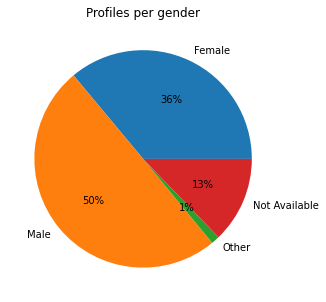

In [18]:
# pie plotting offers per type
plt.figure(figsize=(5,5))
plt.pie(gender_stats, 
        labels=['Female','Male', 'Other', 'Not Available'],
        autopct="%1.0f%%")
plt.title("Profiles per gender")
plt.show()

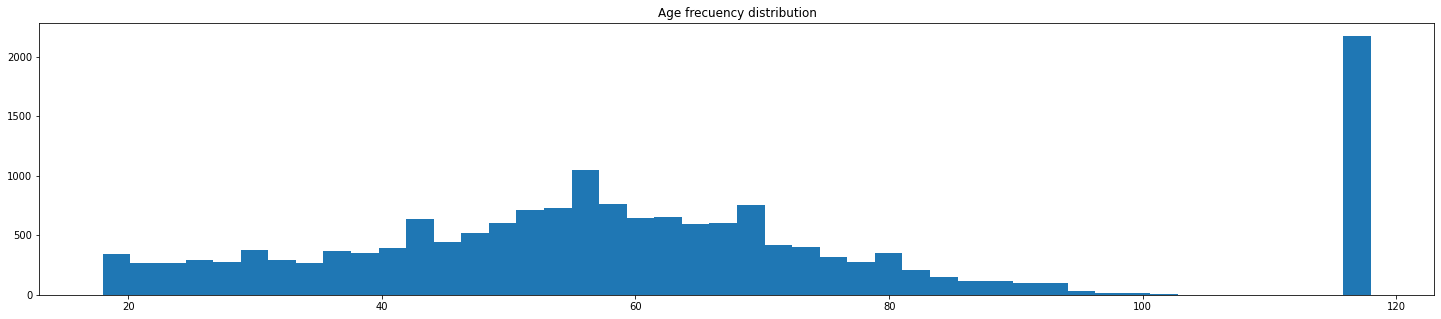

In [19]:
# plotting `age` histogram
plt.figure(figsize=(25,5))
plt.hist(profile.age, bins='auto')
plt.title('Age frecuency distribution')
plt.show()

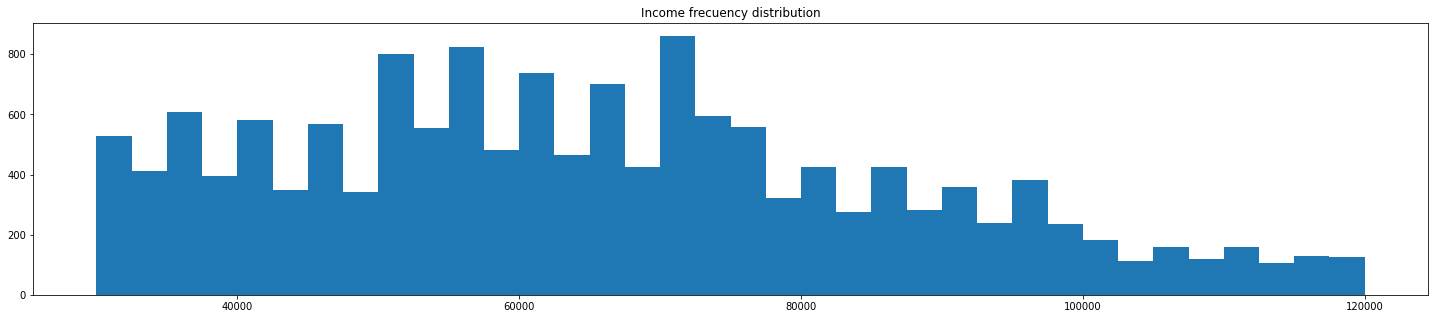

In [20]:
# plotting `income` histogram
plt.figure(figsize=(25,5))
plt.hist(profile.income, bins='auto')
plt.title('Income frecuency distribution')
plt.show()

### Transcript data overview

Shows an overview of portfolio data, comprising:

* First 5 rows of the dataset
* An overview of columns (person, event, value, time) 
* Statistics per columns (count, mean, standard deviation, and quartiles)
* A pie plot depicting the number of transcripts per event
* A pie plot depicting the number of transcripts generated by profiles without demographic (age, gender, and income) information
* A pie plot depicting the number of transcripts generated by profiles with demographic data, per type of event
* A pie plot depicting the number of transcripts generated by profiles without demographic data, per type of event

In [21]:
# read in the transcript json file
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [22]:
# show first 5 rows of the dataset
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [23]:
# show transcript columns overview, looking for null values and double checking data types
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
# show statistics per numerical column, double checking non existence of negative values
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [25]:
# double checking trancript event allowed values
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [26]:
# number of transcripts per event
event_stats = transcript.groupby('event').size()
event_stats

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
dtype: int64

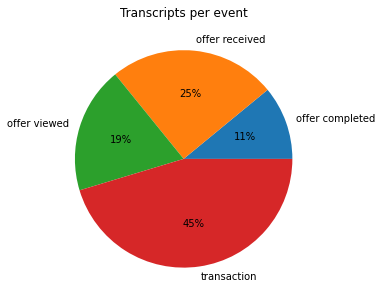

In [27]:
# pie plotting transcripts per type
plt.figure(figsize=(5,5))
plt.pie(event_stats, 
        labels=['offer completed','offer received', 'offer viewed', 'transaction'],
        autopct="%1.0f%%")
plt.title("Transcripts per event")
plt.show()

In [28]:
# get transcripts per type of profile (with and without demographic data)
demotranscript = transcript.merge(profile, how='left', left_on='person', right_on='id')
demotranscript_stats = [demotranscript[demotranscript.age != 118].shape[0], demotranscript[demotranscript.age == 118].shape[0]]
demotranscript_stats

[272762, 33772]

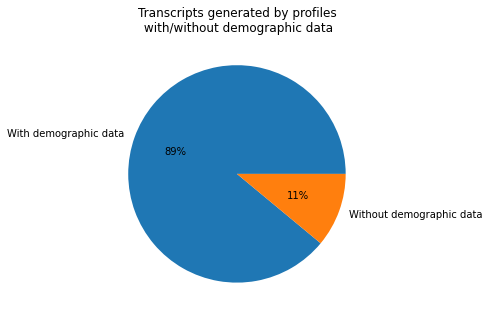

In [29]:
# pie plotting transcripts per type of profile (with and without demographic data)
plt.figure(figsize=(5,5))
plt.pie(demotranscript_stats, 
        labels=['With demographic data','Without demographic data'],
        autopct="%1.0f%%")
plt.title("Transcripts generated by profiles\n with/without demographic data")
plt.show()

In [30]:
# get transcripts generated by profiles with demographic data, per type of event
demo_trans_stats = demotranscript[demotranscript.age != 118].groupby('event').size()
demo_trans_stats

event
offer completed     32444
offer received      66501
offer viewed        49860
transaction        123957
dtype: int64

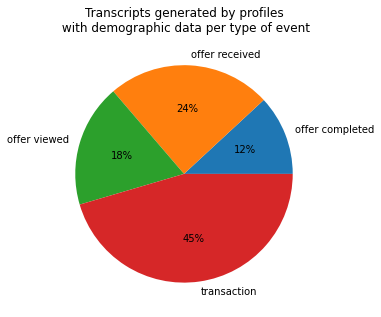

In [31]:
# pie plotting transcripts generated by profiles with demographic data, per type of event
plt.figure(figsize=(5,5))
plt.pie(demo_trans_stats, 
        labels=['offer completed','offer received', 'offer viewed', 'transaction'],
        autopct="%1.0f%%")
plt.title("Transcripts generated by profiles\n with demographic data per type of event")
plt.show()

In [32]:
# get transcripts generated by profiles without demographic data, per type of event
nodemo_trans_stats = demotranscript[demotranscript.age == 118].groupby('event').size()
nodemo_trans_stats

event
offer completed     1135
offer received      9776
offer viewed        7865
transaction        14996
dtype: int64

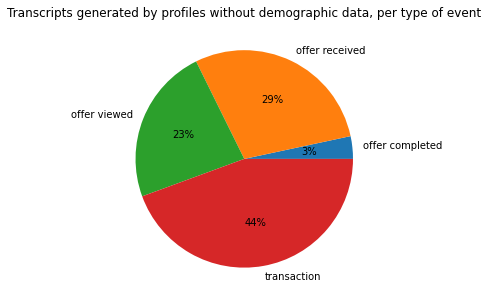

In [33]:
# pie plotting transcripts generated by profiles without demographic data, per type of event
plt.figure(figsize=(5,5))
plt.pie(nodemo_trans_stats, 
        labels=['offer completed','offer received', 'offer viewed', 'transaction'],
        autopct="%1.0f%%")
plt.title("Transcripts generated by profiles without demographic data, per type of event")
plt.show()

# Methodology

## Approach overview
The approach to achieve the business goal is to combine demographic and transcript data to predict whether or not someone will respond to a `bogo` and `discount` offer. In order to do so, it is required to identify the profiles keen to 1) view and 2) complete the offers before they expire, in contrast to those that either a) do not view, or b) do view but do not complete the offers before they expire, c) do view and complete the offers, but viewing is post-completing.

## Data pre-processing

### Portfolio data pre-processing

In [34]:
def get_portfolio():
    """ Retrieve and pre-process portfolio data.
    
    Pre-processing steps:
        * Offer types are depicted in dummy columns.
        * Offer duration is depicted in hours.
        * `id` column is renamed as `offer_id`.
        * `duration` is renamed as `duration_hs`.
        * Columns are re-ordered.
    
    Return.
        Pandas Dataframe. Pre processed portfolio data.
    
    """
    # read in the json file
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    
    # offer type as dummy columns
    portfolio_data = pd.get_dummies(portfolio, columns=['offer_type'])
    
    # portfolio `duration` in hours
    portfolio_data.duration = portfolio.duration.apply(lambda x: x*24)
    
    # rename `id` column as `offer_id`, and `duration` as `duration_hs`
    portfolio_data.rename(columns={'id':'offer_id', 'duration':'duration_hs'}, inplace=True)
    
    # reorder columns
    portfolio_data = portfolio_data[['offer_id',
                                    'channels',
                                    'duration_hs',
                                    'difficulty',
                                    'reward',
                                    'offer_type_bogo',
                                    'offer_type_discount',
                                    'offer_type_informational']]
    
    return portfolio_data

In [35]:
portfolio = get_portfolio()

In [36]:
portfolio.head(10)

,offer_id,channels,duration_hs,difficulty,reward,offer_type_bogo,offer_type_discount,offer_type_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",168,10,10,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",120,10,10,1,0,0
2,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",96,0,0,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",168,5,5,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",240,20,5,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",168,7,3,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",240,10,2,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",72,0,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",120,5,5,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",168,10,2,0,1,0


In [37]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   offer_id                  10 non-null     object
 1   channels                  10 non-null     object
 2   duration_hs               10 non-null     int64 
 3   difficulty                10 non-null     int64 
 4   reward                    10 non-null     int64 
 5   offer_type_bogo           10 non-null     uint8 
 6   offer_type_discount       10 non-null     uint8 
 7   offer_type_informational  10 non-null     uint8 
dtypes: int64(3), object(2), uint8(3)
memory usage: 558.0+ bytes


### Profile data pre-processing

In [38]:
def get_profile():
    """ Retrieve and pre-process profile data.
    
    Pre-processing steps:
        * Profile genders are depicted in dummy columns, as `male`, `female`, and `other`.
        * Gender null values are depicted in `gender_na` column.
        * `became_member_on` column is replaced by the `membership_days` column.
            The values are calculated as the number of days up to today.
        * `id` column is renamed as `profile_id`.
        * Columns are reordered.
    
    Return.
        Pandas Dataframe. Pre-processed profile data.
        
    """
    # read in the json file
    profile_data = pd.read_json('data/profile.json', orient='records', lines=True)
    
    # replace gender letters by more informative labels
    profile_data.gender = profile_data.gender.map({'M':'male', 'F':'female', 'O':'other'}, na_action='ignore')
    
    # fill in gender missing values
    profile_data.fillna(value={'gender':'na',}, inplace=True)
    
    # gender as dummy columns
    profile_data = pd.get_dummies(profile_data, columns=['gender'], prefix='gender', prefix_sep='_')
    
    # generate `membership_days` columns from `became_member_on` column
    # membership_days values are calculated as the number of days up to today
    profile_data.became_member_on = pd.to_datetime(profile_data.became_member_on, format='%Y%m%d')
    profile_data['membership_days'] = profile_data.became_member_on.apply(lambda x: (datetime.today() - x).days)
    
    # drop `became_member_on` column
    profile_data.drop('became_member_on', axis=1, inplace=True)
    
    # rename `id` column as `profile_id`
    profile_data.rename(columns={'id':'profile_id'}, inplace=True)
    
    # reorder columns
    profile_data = profile_data[['profile_id',
                                   'age',
                                   'income',
                                   'membership_days',
                                   'gender_male',
                                   'gender_female',
                                   'gender_other',
                                   'gender_na']]
    
    return profile_data

In [39]:
profile = get_profile()

In [40]:
profile.head()

,profile_id,age,income,membership_days,gender_male,gender_female,gender_other,gender_na
0,68be06ca386d4c31939f3a4f0e3dd783,118,NaN,2041,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,1888,0,1,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,118,NaN,1526,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,1955,0,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,118,NaN,1868,0,0,0,1


In [41]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   profile_id       17000 non-null  object 
 1   age              17000 non-null  int64  
 2   income           14825 non-null  float64
 3   membership_days  17000 non-null  int64  
 4   gender_male      17000 non-null  uint8  
 5   gender_female    17000 non-null  uint8  
 6   gender_other     17000 non-null  uint8  
 7   gender_na        17000 non-null  uint8  
dtypes: float64(1), int64(2), object(1), uint8(4)
memory usage: 597.8+ KB


### Transcript data pre-processing

In [42]:
def get_offers_transcript():
    """ Retrieve and pre-process offers transcript data.
    
    Pre-processing steps:
        * Trasaction events are discarded.
        * `person` column is renamed as `profile_id`.
        * `value` column is renamed as `offer_id`.
        * dictionary in renamed `offer_id` column is replaced by the offer id value.
        * `offer_expiration` columns is added depicting expiration time per offer received.
        * `offer_received` column is added depicting offer reception time.
        * `offer_viewed` column is added depicting offer viewing time (NaN if not viewed).
        * `offer_completed` column is added depicting offer completion time (NaN if not completed).
    
    Return.
        Pandas Dataframe. Pre-processed transcript data.
        
    """
    # read in the json file
    transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
    
    # get transcript data only about offers
    offers_transcript = transcript[transcript.event != 'transaction'].copy()

    # rename the `person` column as `person_id`
    # rename the `value` column as `offer_id`
    offers_transcript.rename(columns={'person':'profile_id', 'value':'offer_id'}, inplace=True)

    # dict object in `offer_id` column is replaced by the value (offer id) as string
    offers_transcript.offer_id = offers_transcript.offer_id.apply(lambda x: list(x.values())[0])
    
    # offer event values cleaning
    offers_transcript.event = offers_transcript.event.map({'offer received':'offer_received',
                                                           'offer viewed':'offer_viewed',
                                                           'offer completed':'offer_completed'
                                                          })
    # remove duplicates
    offers_transcript.drop_duplicates(inplace=True)

    # get offers `expiration` time (in hours since offer received) 
    expiration_times = get_expiration_times(offers_transcript)

    # add expiration times as a column of transcripts data depicting offers
    offers_transcript['offer_expiration'] = expiration_times

    # pivot the table to get all the events time data per customer and per offer, in a single row
    offers_transcript = pd.pivot_table(offers_transcript,
                                       values='time',
                                       index=['profile_id', 'offer_id', 'offer_expiration'],
                                       columns='event')

    # reset the generated multi-index to default
    offers_transcript.reset_index(inplace=True)
    
    return offers_transcript


def get_expiration_times(offers_transcript):
    """ Set up the offer expiration time
    
    Args.
        offers_transcript (pandas dataframe) - Offers transcript data.
        
    Return.
        Pandas Series. Expiration time of the offers.
    
    """
    try: # if the expiration times are available, just retrieve them
        
        expiration_times = pd.read_csv('./data/expiration_times.csv', index_col=0).squeeze("columns")
        return expiration_times
        
    except FileNotFoundError: # otherwise, run the process to calculate them
        
        # get offers duration in hours
        portfolio = get_portfolio()
        offers_duration = pd.Series(portfolio.duration_hs.values, index=portfolio.offer_id)
        
        expiration_list = []
        # for each row in transcript data
        for _, offer in offers_transcript.iterrows():
        
            # if it's an `offer received` event, add up the duration to the event time
            if offer.event == 'offer_received':
                expiration = offers_duration[offer.offer_id] + offer.time
        
            # for `offer viewed` and `offer completed` events,
            # add up the duration to the corresponding offer reception event time
            else:
                # filter out the transcript data by person id, offer id, type of event,
                # and event occurring before/at the same time the current one
                # sort data by occurrence time in descending order
                offers_reception = offers_transcript.query(f"""profile_id == '{offer.profile_id}' and \
                                                            offer_id == '{offer.offer_id}' and \
                                                            event == 'offer_received' and \
                                                            time <= {offer.time}""").sort_values(by=['time'], ascending=False)

                # last offer reception event
                last_offer_reception_time = offers_reception.time.values[0]
                
                # add up the duration and the last event reception time
                expiration = offers_duration[offer.offer_id] + last_offer_reception_time
            
            expiration_list.append(expiration)
        
        # serialize the expiration times and return the data as a pandas series
        expiration_times = pd.Series(expiration_list, index=offers_transcript.index)
        expiration_times.to_csv('./data/expiration_times.csv')
        return expiration_times

In [43]:
offers_transcript = get_offers_transcript()

In [44]:
offers_transcript.head()

event,profile_id,offer_id,offer_expiration,offer_completed,offer_received,offer_viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,744,576.0,576.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,432,NaN,336.0,372.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,240,NaN,168.0,192.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,528,414.0,408.0,456.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,744,528.0,504.0,540.0


In [45]:
offers_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   profile_id        76277 non-null  object 
 1   offer_id          76277 non-null  object 
 2   offer_expiration  76277 non-null  int64  
 3   offer_completed   33101 non-null  float64
 4   offer_received    76277 non-null  float64
 5   offer_viewed      57725 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 3.5+ MB


### Dataset preparation

In [46]:
def get_dataset():
    """ Merge pre-processed portfolio, profile and transcript data into a single dataset.
    
    Return.
        Pandas Dataframe. Single dataset.
    
    """
    # get pre processed portfolio, profile, and transcript data
    portfolio = get_portfolio()
    profile = get_profile()
    offers_transcript = get_offers_transcript()
    
    # perform merging
    dataset = offers_transcript.merge(profile, how='inner', on='profile_id') \
                                .merge(portfolio, how='inner', on='offer_id')
    
    # remove rows about `informational` offers
    dataset.drop(dataset[dataset.offer_type_informational == 1].index, axis=0, inplace=True)
    
    # remove rows about 118 years old profiles
    dataset.drop(dataset[dataset.age == 118].index, axis=0, inplace=True)
   
    # get the index of successful offers
    successful_offers_index = dataset.query("""~offer_viewed.isna() and \
                                            ~offer_completed.isna() and \
                                            offer_viewed <= offer_completed and \
                                            offer_completed <= offer_expiration""").index
    # create a series and set the successful offers index to 1
    successful_offer = pd.Series(0, index=dataset.index)
    successful_offer.loc[successful_offers_index] = 1
    # add success offer column
    dataset['successful_offer'] = successful_offer
    
    # rename columns
    dataset.rename(columns={'age':'profile_age',
                                   'income':'profile_income',
                                   'membership_days': 'profile_membership_days', 
                                   'gender_male': 'profile_gender_male',
                                   'gender_female': 'profile_gender_female', 
                                   'gender_other': 'profile_gender_other', 
                                   'duration_hs': 'offer_duration_hs', 
                                   'difficulty': 'offer_difficulty', 
                                   'reward': 'offer_reward', 
                                  }, inplace=True)
    
    # serialize dataset for cache purposes
    dataset.to_csv('./data/dataset.csv', index=False)
    
    # remove unused columns
    dataset.drop(['offer_expiration',
                  'offer_completed',
                  'offer_received',
                  'offer_viewed',
                  'profile_id',
                  'gender_na',
                  'offer_id',
                  'channels',
                  'offer_type_informational'], axis=1, inplace=True)
    
    return dataset

### Dataset overview

Shows an overview of the dataset, comprising:

* First 5 rows of the dataset
* An overview of columns (person, event, value, time) 
* Statistics per columns (count, mean, standard deviation, and quartiles)
* A violin plot of numeric features, both demographic and portfolio ones
* A plot depicting pairwise relationships between the numeric features in the dataset

In [47]:
dataset = get_dataset()

In [48]:
dataset.head()

,profile_age,profile_income,profile_membership_days,profile_gender_male,profile_gender_female,profile_gender_other,offer_duration_hs,offer_difficulty,offer_reward,offer_type_bogo,offer_type_discount,successful_offer
0,33,72000.0,1973,1,0,0,168,10,2,0,1,0
1,19,65000.0,2228,0,1,0,168,10,2,0,1,0
2,19,65000.0,2228,0,1,0,168,10,2,0,1,0
3,56,47000.0,1741,1,0,0,168,10,2,0,1,0
6,58,119000.0,1743,0,1,0,168,10,2,0,1,0


In [49]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53201 entries, 0 to 76276
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   profile_age              53201 non-null  int64  
 1   profile_income           53201 non-null  float64
 2   profile_membership_days  53201 non-null  int64  
 3   profile_gender_male      53201 non-null  uint8  
 4   profile_gender_female    53201 non-null  uint8  
 5   profile_gender_other     53201 non-null  uint8  
 6   offer_duration_hs        53201 non-null  int64  
 7   offer_difficulty         53201 non-null  int64  
 8   offer_reward             53201 non-null  int64  
 9   offer_type_bogo          53201 non-null  uint8  
 10  offer_type_discount      53201 non-null  uint8  
 11  successful_offer         53201 non-null  int64  
dtypes: float64(1), int64(6), uint8(5)
memory usage: 5.5 MB


In [50]:
dataset.describe()

,profile_age,profile_income,profile_membership_days,profile_gender_male,profile_gender_female,profile_gender_other,offer_duration_hs,offer_difficulty,offer_reward,offer_type_bogo,offer_type_discount,successful_offer
count,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000,53201.000000
mean,54.321610,65371.590760,2033.901938,0.574463,0.411985,0.013552,174.223642,9.642676,5.248510,0.498806,0.501194,0.419955
std,17.384883,21639.081109,419.247733,0.494429,0.492197,0.115624,42.839150,4.457880,2.987384,0.500003,0.500003,0.493556
min,18.000000,30000.000000,1512.000000,0.000000,0.000000,0.000000,120.000000,5.000000,2.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,1719.000000,0.000000,0.000000,0.000000,168.000000,7.000000,3.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,1869.000000,1.000000,0.000000,0.000000,168.000000,10.000000,5.000000,0.000000,1.000000,0.000000
75%,66.000000,80000.000000,2310.000000,1.000000,1.000000,0.000000,240.000000,10.000000,5.000000,1.000000,1.000000,1.000000
max,101.000000,120000.000000,3335.000000,1.000000,1.000000,1.000000,240.000000,20.000000,10.000000,1.000000,1.000000,1.000000


In [51]:
# get offers success versus non-successful offers
offer_stats = dataset.groupby('successful_offer').size()
offer_stats

successful_offer
0    30859
1    22342
dtype: int64

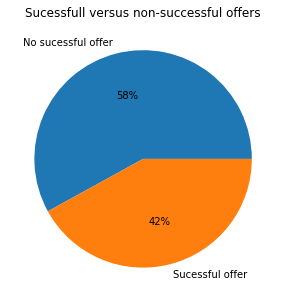

In [52]:
# pie plotting offers success versus no successful offers
plt.figure(figsize=(5,5))
plt.pie(offer_stats, 
        labels=['No sucessful offer','Sucessful offer'],
        autopct="%1.0f%%")
plt.title("Sucessfull versus non-successful offers")
plt.show()

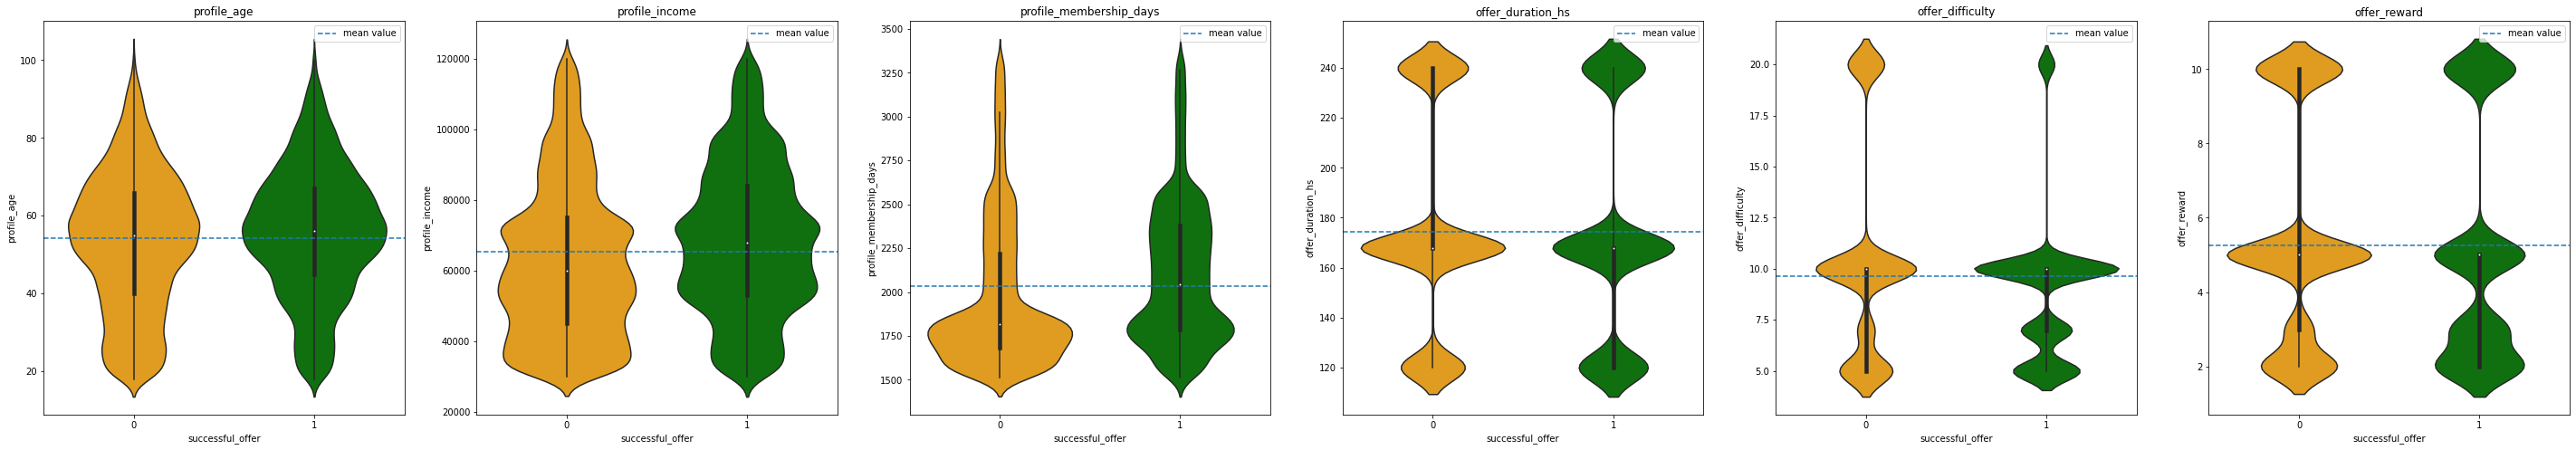

In [53]:
# violin plot of numeric features, both demographic and portfolio ones
features = dataset[['profile_age', 'profile_income', 'profile_membership_days', 'offer_duration_hs', 'offer_difficulty', 'offer_reward']]

plt.figure(figsize=(50,8))
index = 0
for f in features:
    plt.subplot(1,6,index+1)
    sns.violinplot(x=dataset.successful_offer, y=dataset[f], palette=["orange","green"])
    plt.title(f)
    plt.axhline(dataset[f].mean(), linestyle = "dashed", label='mean value')
    plt.legend(loc="best")
    index += 1

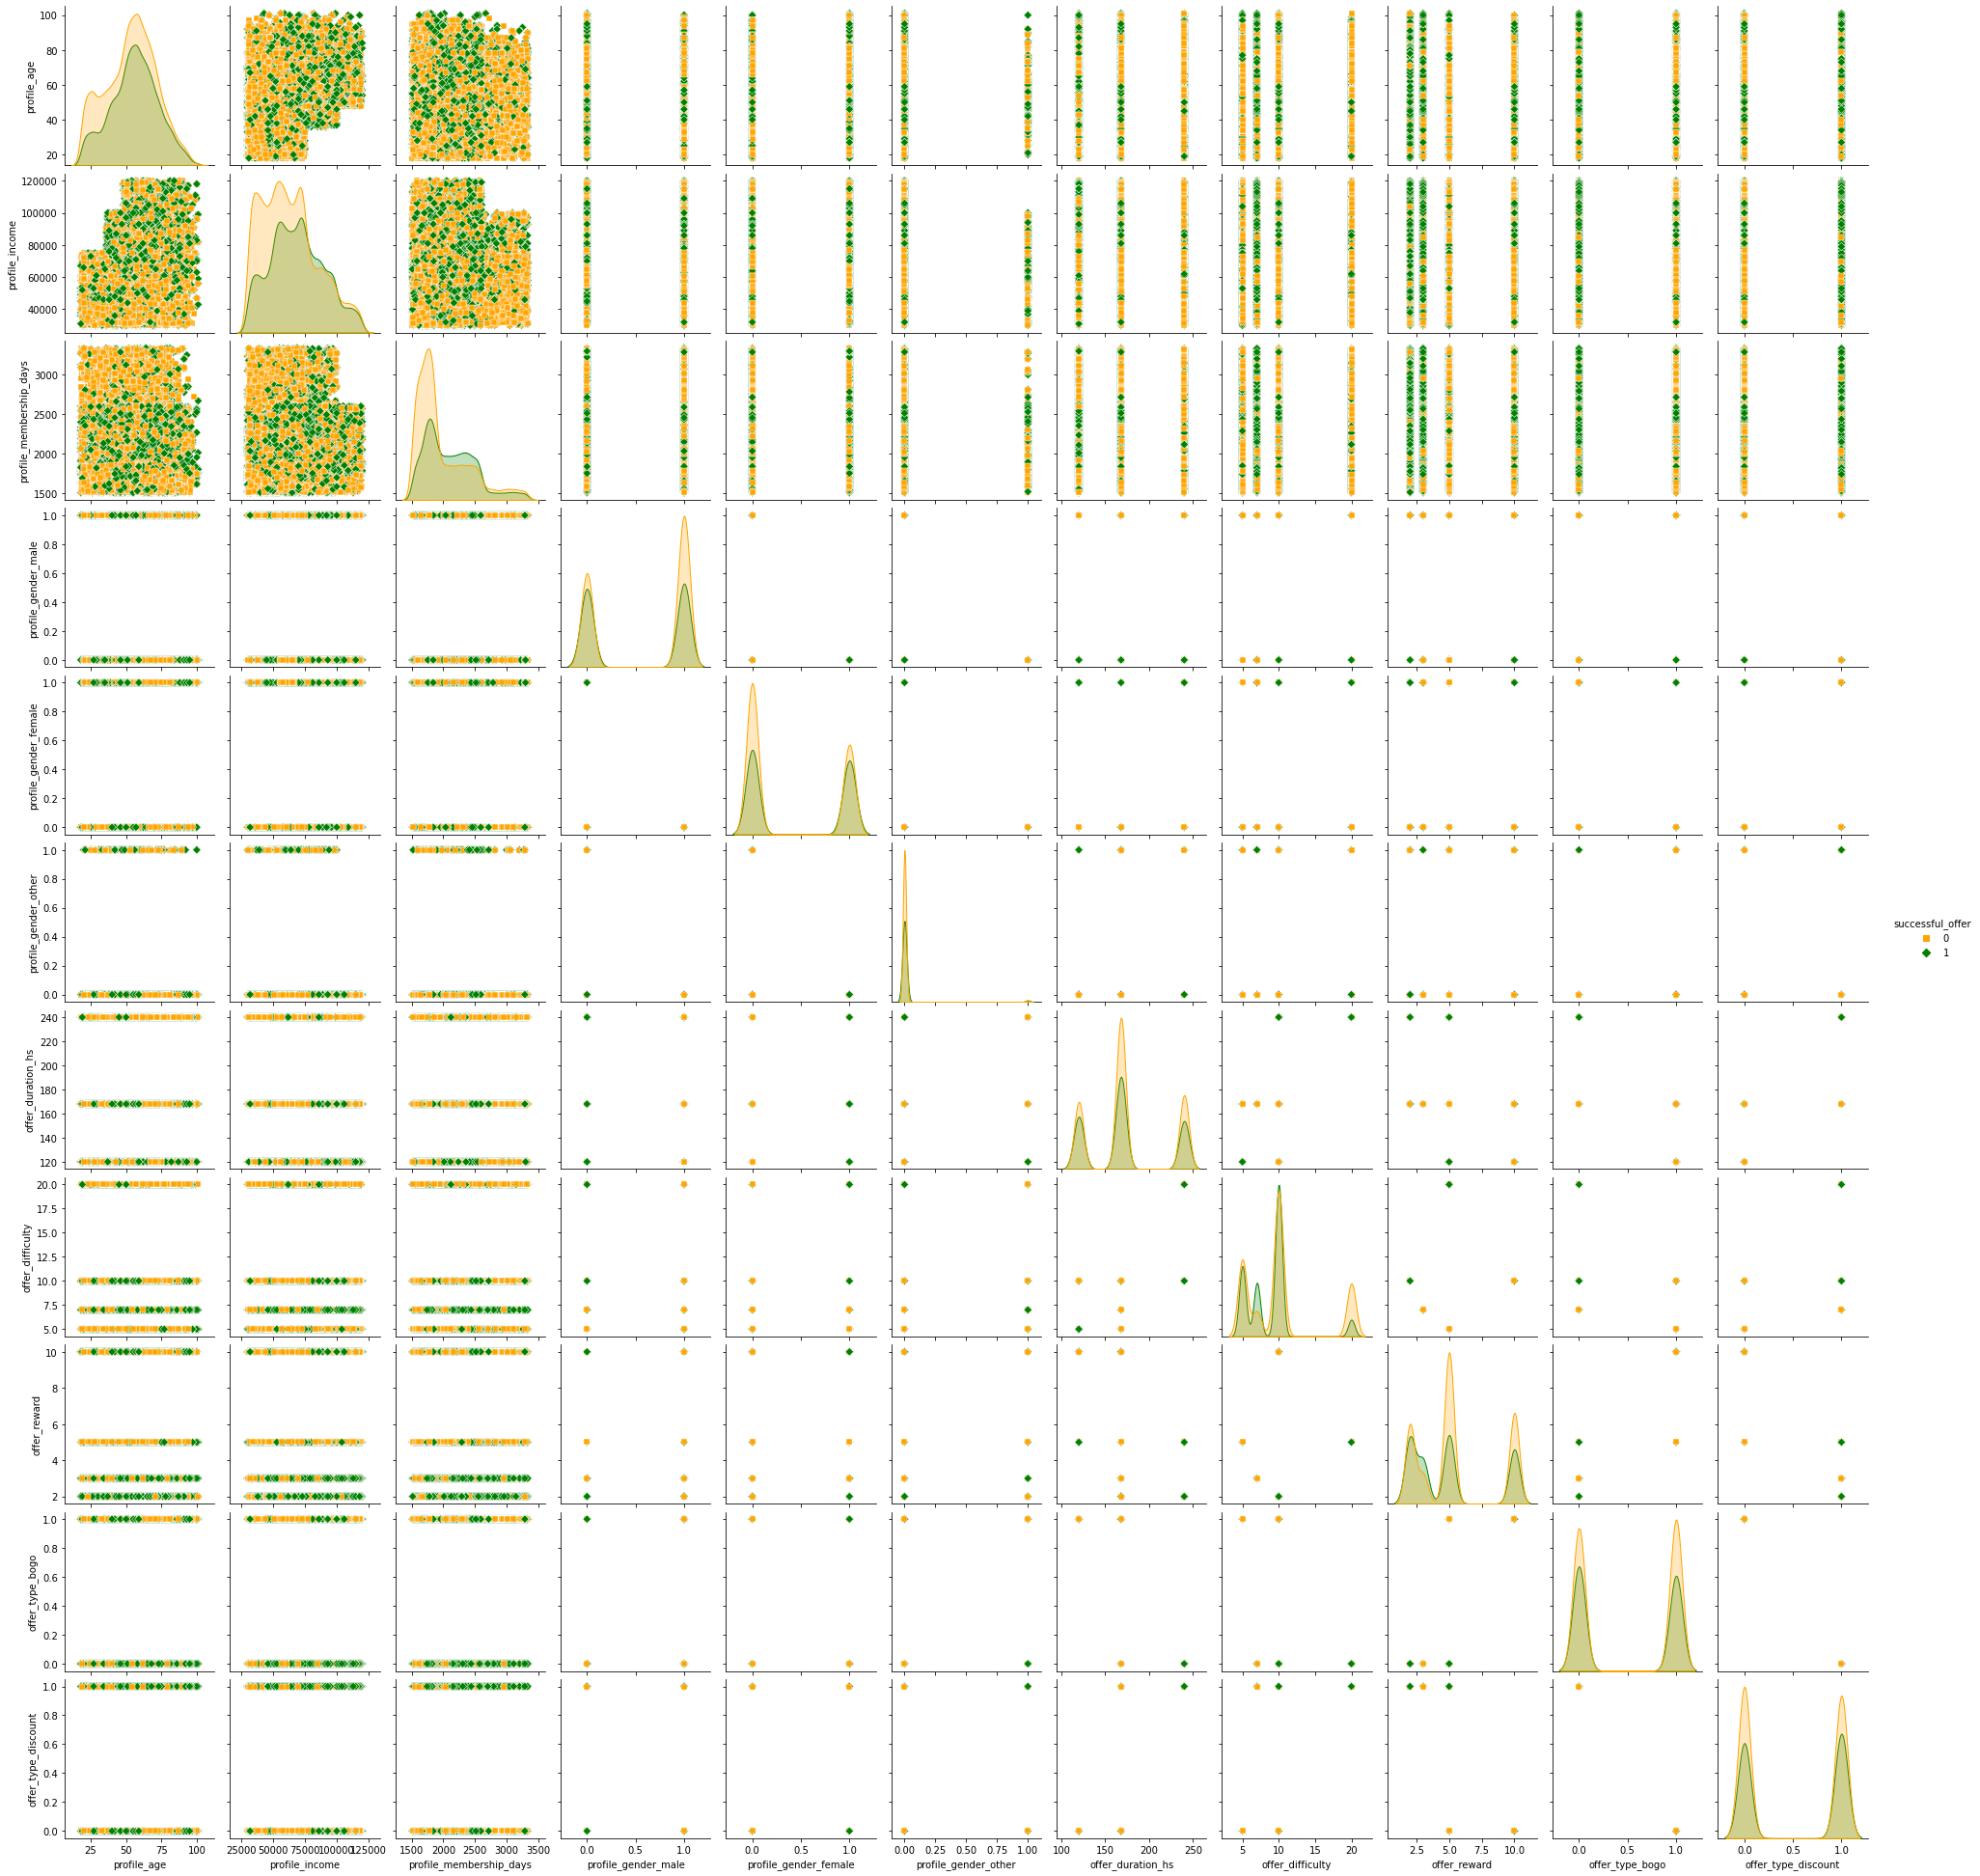

In [54]:
# pairplot between features
sns.pairplot(dataset, hue="successful_offer", palette=["orange","green"], markers=['s', 'D'])

**By reviewing the previous violin and features pairwise plots, it seems to be clear that successful versus non-successful offers are not clearly separated, according to profile demographic and porfolio features data.**

# Classification model
## Implementation

The goal of this section is to analize the performance in terms of precision, recall and F1-score of the following commonly applied classification models:
* Logistic Regression,
* Decision Tree,
* Random Forest,
* Gradient Boosting,
* XGB, and
* MLP

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [56]:
# get feature values array
X = dataset.drop('successful_offer', axis=1).values

# get target values
y = dataset.successful_offer.values

# train and test splitting. 
# test set comprises 33% of the dataset entries.
# random_state param fixed value because of results reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21, shuffle=True)

LRG
Accuracy on training set: 0.64
Accuracy on testing set: 0.64
Confusion matrix:


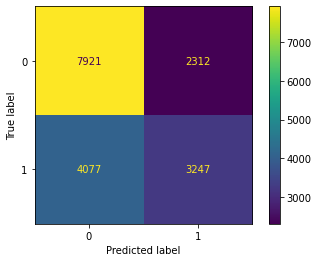

Classification report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71     10233
           1       0.58      0.44      0.50      7324

    accuracy                           0.64     17557
   macro avg       0.62      0.61      0.61     17557
weighted avg       0.63      0.64      0.63     17557

DTC
Accuracy on training set: 0.96
Accuracy on testing set: 0.63
Confusion matrix:


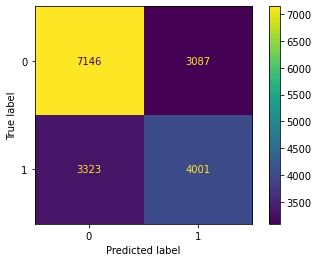

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69     10233
           1       0.56      0.55      0.56      7324

    accuracy                           0.63     17557
   macro avg       0.62      0.62      0.62     17557
weighted avg       0.63      0.63      0.63     17557

RFC
Accuracy on training set: 0.96
Accuracy on testing set: 0.68
Confusion matrix:


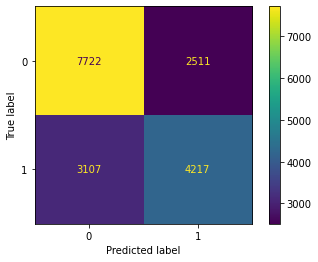

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73     10233
           1       0.63      0.58      0.60      7324

    accuracy                           0.68     17557
   macro avg       0.67      0.67      0.67     17557
weighted avg       0.68      0.68      0.68     17557

GBC
Accuracy on training set: 0.71
Accuracy on testing set: 0.7
Confusion matrix:


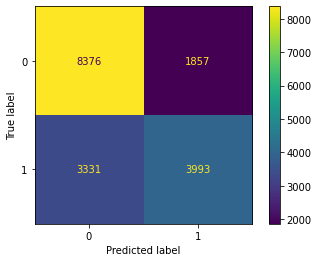

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.82      0.76     10233
           1       0.68      0.55      0.61      7324

    accuracy                           0.70     17557
   macro avg       0.70      0.68      0.68     17557
weighted avg       0.70      0.70      0.70     17557

XGB
Accuracy on training set: 0.76
Accuracy on testing set: 0.7
Confusion matrix:


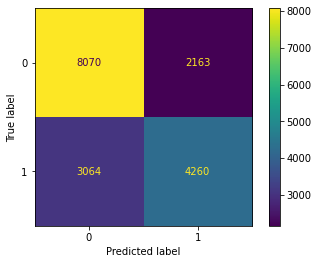

Classification report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.76     10233
           1       0.66      0.58      0.62      7324

    accuracy                           0.70     17557
   macro avg       0.69      0.69      0.69     17557
weighted avg       0.70      0.70      0.70     17557

MLP
Accuracy on training set: 0.7
Accuracy on testing set: 0.7
Confusion matrix:


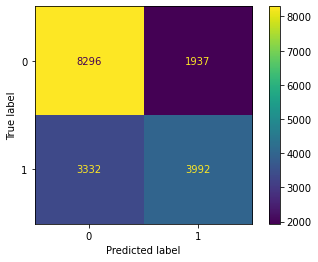

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.81      0.76     10233
           1       0.67      0.55      0.60      7324

    accuracy                           0.70     17557
   macro avg       0.69      0.68      0.68     17557
weighted avg       0.70      0.70      0.69     17557



In [57]:
# models to try, default parameters in all the cases
models = [['LRG', LogisticRegression, {}],
          ['DTC', DecisionTreeClassifier, {}],
          ['RFC', RandomForestClassifier, {}],
          ['GBC', GradientBoostingClassifier, {}],
          ['XGB', XGBClassifier, {}], 
          ['MLP', MLPClassifier, {}]]

# for each model to try
for modelname, model, params in models:
    
    # create a pipeline composed by: a) a scaler, and b) the model with default params
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('model', model(**params))])
    
    # pipelined fitting
    pipeline.fit(X_train, y_train)
    
    # printing model training and prediction metrics
    print(modelname)
    
    # printing model accuracy on both training and testing set
    print(f'Accuracy on training set: {round(pipeline.score(X_train, y_train), 2)}')
    print(f'Accuracy on testing set: {round(pipeline.score(X_test, y_test), 2)}')
    
    # generate predictions
    y_pred = pipeline.predict(X_test)
    
    # printing confusion matrix
    print('Confusion matrix:')
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=pipeline['model'].classes_)
    plt.show()
    
    # printing classification reports
    print('Classification report:')
    print(classification_report(y_test, y_pred))

## Refinement


In [68]:
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Dropout

In [69]:
# get feature values array
X = dataset.drop('successful_offer', axis=1).values

# get target values
y = dataset.successful_offer.values

# train and test splitting. 
# test set comprises 33% of the dataset entries.
# random_state param fixed value because of results reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21, shuffle=True)

In [70]:
# define a sequential model
model = Sequential()

# first hidden layer
model.add(Dense(48,activation='relu',input_dim=11))
model.add(Dropout(0.25))

# second hidden layer
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.25))

# third hidden layer
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))

# fourth hidden layer
model.add(Dense(11,activation='relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(1,activation='sigmoid'))

# compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# printing a model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 48)                576       
                                                                 
 dropout_4 (Dropout)         (None, 48)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1568      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 11)               

In [71]:
# class weights 
# because of the class imbalance, misclassification of successful offerings has a higher penalty
# penalty is established as the relationship betwen number of unsuccessful offerings and successful ones.
weight = {0:1., 1:((y_train.shape[0]-y_train.sum())/y_train.sum())}

In [72]:
# scaling training data
sc = StandardScaler()
sc_X_train = sc.fit_transform(X_train)

# fitting the model in 100 epochs
# using test data for validation
history = model.fit(sc_X_train, y_train, epochs=100, class_weight=weight, validation_data = (sc.transform(X_test),y_test), verbose=2)

Epoch 1/100
1114/1114 - 6s - loss: 0.7656 - accuracy: 0.6013 - val_loss: 0.6209 - val_accuracy: 0.6625 - 6s/epoch - 5ms/step
Epoch 2/100
1114/1114 - 3s - loss: 0.7308 - accuracy: 0.6562 - val_loss: 0.6165 - val_accuracy: 0.6704 - 3s/epoch - 3ms/step
Epoch 3/100
1114/1114 - 4s - loss: 0.7175 - accuracy: 0.6692 - val_loss: 0.5988 - val_accuracy: 0.6898 - 4s/epoch - 4ms/step
Epoch 4/100
1114/1114 - 5s - loss: 0.7137 - accuracy: 0.6751 - val_loss: 0.5950 - val_accuracy: 0.6879 - 5s/epoch - 4ms/step
Epoch 5/100
1114/1114 - 4s - loss: 0.7091 - accuracy: 0.6768 - val_loss: 0.5921 - val_accuracy: 0.6951 - 4s/epoch - 4ms/step
Epoch 6/100
1114/1114 - 5s - loss: 0.7076 - accuracy: 0.6775 - val_loss: 0.5952 - val_accuracy: 0.6879 - 5s/epoch - 4ms/step
Epoch 7/100
1114/1114 - 4s - loss: 0.7072 - accuracy: 0.6773 - val_loss: 0.6088 - val_accuracy: 0.6768 - 4s/epoch - 4ms/step
Epoch 8/100
1114/1114 - 4s - loss: 0.7051 - accuracy: 0.6820 - val_loss: 0.5894 - val_accuracy: 0.6894 - 4s/epoch - 4ms/step


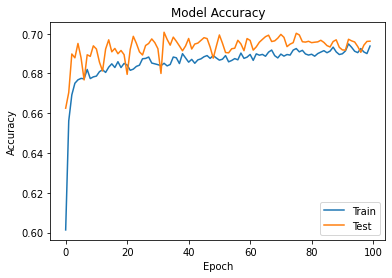

In [73]:
# depicting accuracy for both training and test data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

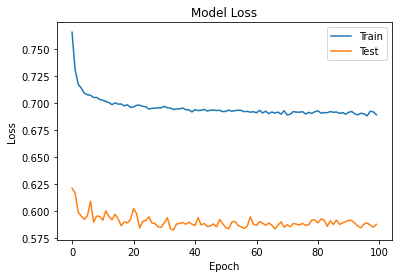

In [74]:
# depicting loss for both training and test data
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model Loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper right') 
plt.show()

# Results

In [75]:
# model prediction
y_pred = np.round(model.predict(sc.transform(X_test)))

549/549 [==============================] - 1s 2ms/step


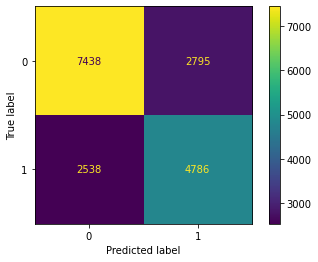

In [76]:
# printing confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[0, 1])
plt.show()

In [77]:
# printing classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     10233
           1       0.63      0.65      0.64      7324

    accuracy                           0.70     17557
   macro avg       0.69      0.69      0.69     17557
weighted avg       0.70      0.70      0.70     17557



# Conclusion

The following three bullet point depicts the main results achieved by all of the experiments performed in this pŕoject:
* no classification model shows an accuracy on the testing set above 70%,
* no classification model shows a F1 score on the unsuccessful offer class above 76%, and,
* no classification model shows a F1 score for the successful offer class above 64%.

In conclusion, the objective of the project - i.e.: to distinguish customers willing to be influenced by an offer versus those ones do not, in order to maximize the benefits generated by the offers being sent - has been partially achieved in terms of the metrics analyzed.

However, it is important to bear in mind the synthetic nature of the analyzed dataset and the insights presented in the section about dataset analysis. To recap, the profile demographic and portfolio features data do not provides clear insights on how to distinguish entries belonging to the unsuccessful/successful offer classes. In consequence, it is not surprising the difficulty to devise out a classification model since the classes are not easily separable by the features comprised in the dataset.

## Improvement
By considering this project as a baseline for future project, it could be evaluated other options in order to address the business goal in a higher degree. For instance, it could be defined the same goal but including the amount of money spend on the recorded transactions. It could be also helpful to redefine how the benefits maximization is defined.

Instead of comparing unsuccessful versus successful offers, a regression model could be potentially used to predict the amount of money is spent after offer reception and viewing. In this case, not only the *bogo* and *discount* offers should be considered but also the *informative* ones.